In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json

In [2]:
from matplotlib.pylab import rcParams
%matplotlib inline

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import pprint

In [5]:
TEST_DATA_PATH = '../data/origin/test/'
TRAIN_DATA_PATH = '../data/origin/train/'

# instead of weather_station_to_county_mapping.csv, use fabiendaniels-mapping-locations-and-county-codes
# https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
county_mapper = '../data/origin/county_lon_lats.csv'

test_csv = f'{TEST_DATA_PATH}test.csv'
test_client_csv = f'{TEST_DATA_PATH}client.csv'
test_electricity_prices_csv = f'{TEST_DATA_PATH}electricity_prices.csv'
test_forecast_weather_csv = f'{TEST_DATA_PATH}forecast_weather.csv'
test_gas_prices_csv = f'{TEST_DATA_PATH}gas_prices.csv'
test_historical_weather_csv = f'{TEST_DATA_PATH}historical_weather.csv'
# test_weather_station_to_county_mapping_csv = f'{TEST_DATA_PATH}weather_station_to_county_mapping.csv'
# test_county_id_to_name_map_json = f'{TEST_DATA_PATH}county_id_to_name_map.json'

train_csv = f'{TRAIN_DATA_PATH}train.csv'
train_client_csv = f'{TRAIN_DATA_PATH}client.csv'
train_electricity_prices_csv = f'{TRAIN_DATA_PATH}electricity_prices.csv'
train_forecast_weather_csv = f'{TRAIN_DATA_PATH}forecast_weather.csv'
train_gas_prices_csv = f'{TRAIN_DATA_PATH}gas_prices.csv'
train_historical_weather_csv = f'{TRAIN_DATA_PATH}historical_weather.csv'
# train_weather_station_to_county_mapping_csv = f'{TRAIN_DATA_PATH}weather_station_to_county_mapping.csv'
# train_county_id_to_name_map_json = f'{TRAIN_DATA_PATH}county_id_to_name_map.json'

In [6]:
df_train = pd.read_csv(train_csv)
df_train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [ ]:
df_train.info()

In [ ]:
df_train.shape

In [ ]:
# 결측치 확인 부분
df_train.isna().sum()

In [ ]:
df_train[df_train['target'].isna()]

In [ ]:
df_train[df_train['target'].isna()]['county'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['is_business'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['product_type'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['is_consumption'].value_counts()

In [ ]:
df_train[df_train['target'].isna()]['datetime'].value_counts()

In [ ]:
# 일단은 결측치 제거하고 시작
# df_train.dropna(inplace=True)
# df_train['target'].fillna(df_train['target'].shift(24).fillna(df_train['target'].shift(-24).mean()))

In [ ]:
df_train[df_train['target'].isna()].value_counts()

In [ ]:
# 통계적 상황 구경
df_train.describe().T

In [7]:
# TODO: date unique값 처리 - 빠뜨린 시간있는지 확인용?
df_train[(df_train['datetime'] >= '2021-09-01 00:00:00') &
         (df_train['datetime'] <= '2021-09-01 23:00:00')]['datetime'].unique()

array(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
       '2021-09-01 02:00:00', '2021-09-01 03:00:00',
       '2021-09-01 04:00:00', '2021-09-01 05:00:00',
       '2021-09-01 06:00:00', '2021-09-01 07:00:00',
       '2021-09-01 08:00:00', '2021-09-01 09:00:00',
       '2021-09-01 10:00:00', '2021-09-01 11:00:00',
       '2021-09-01 12:00:00', '2021-09-01 13:00:00',
       '2021-09-01 14:00:00', '2021-09-01 15:00:00',
       '2021-09-01 16:00:00', '2021-09-01 17:00:00',
       '2021-09-01 18:00:00', '2021-09-01 19:00:00',
       '2021-09-01 20:00:00', '2021-09-01 21:00:00',
       '2021-09-01 22:00:00', '2021-09-01 23:00:00'], dtype=object)

In [8]:
# TODO: data pandas그거로 바꿈
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

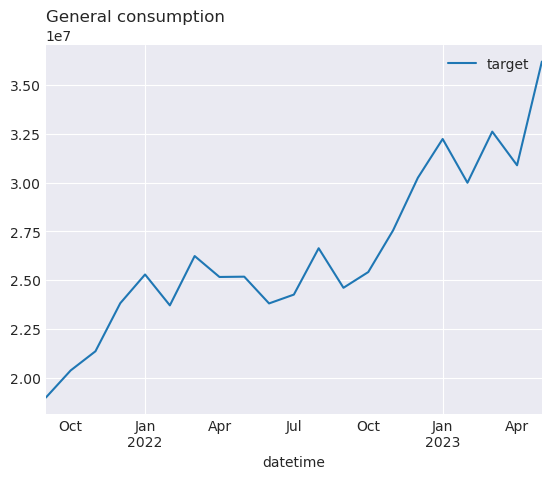

In [9]:
# TODO: datetime set index해서 group by하기
df_train.set_index('datetime').groupby(pd.Grouper(freq='MS'))[['target']].sum().plot()
plt.title('General consumption', loc='left')
plt.show()

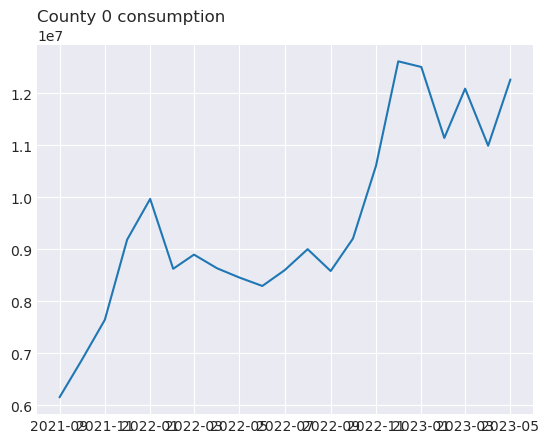

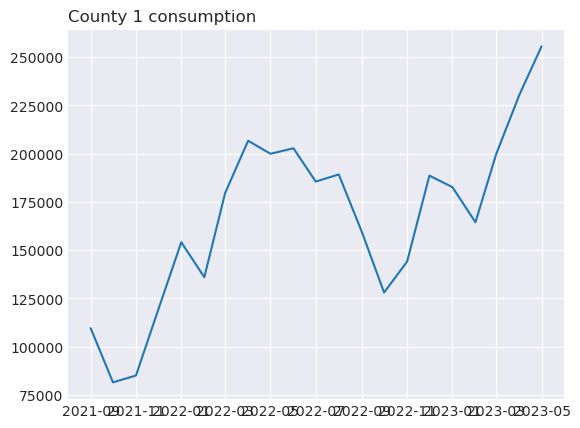

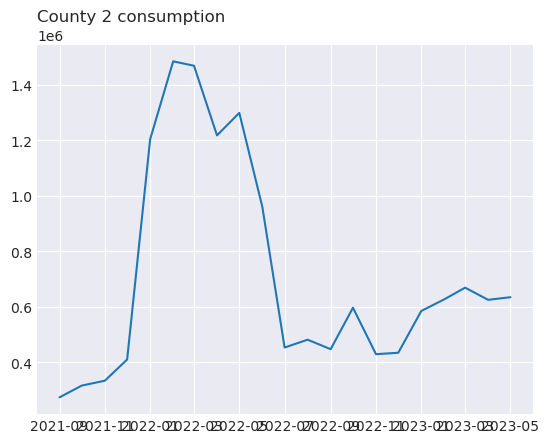

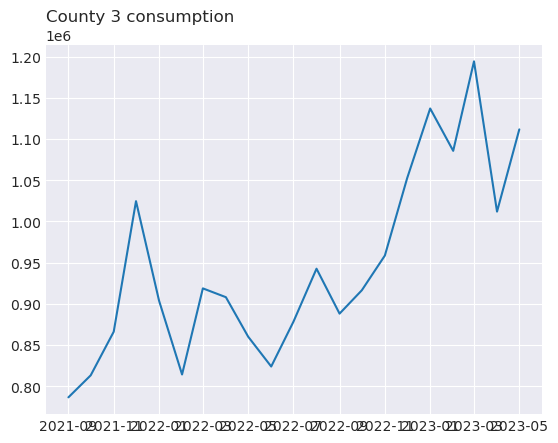

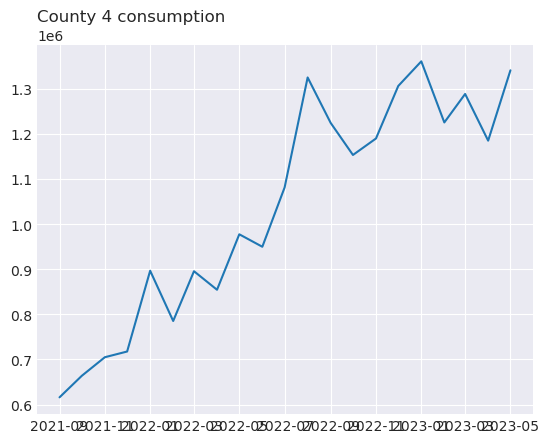

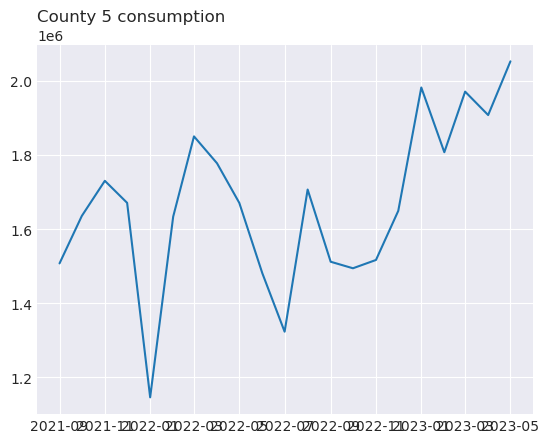

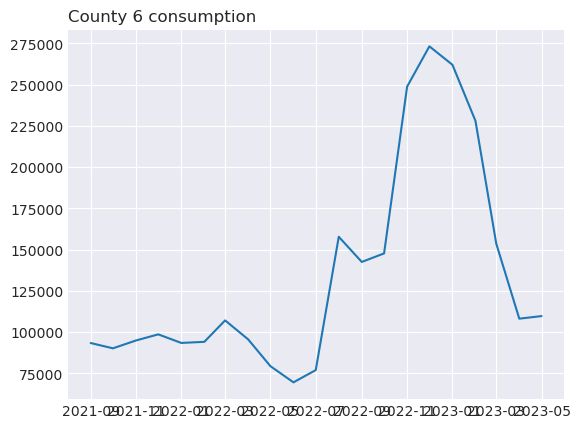

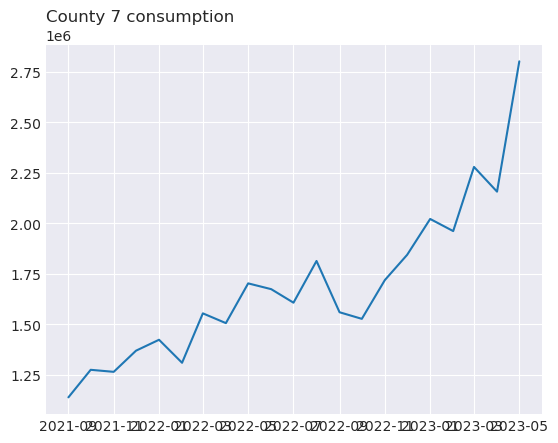

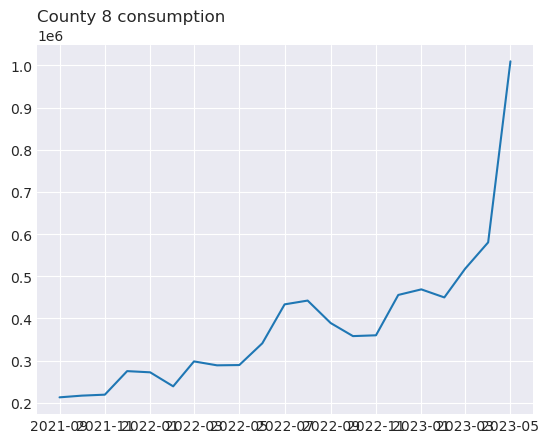

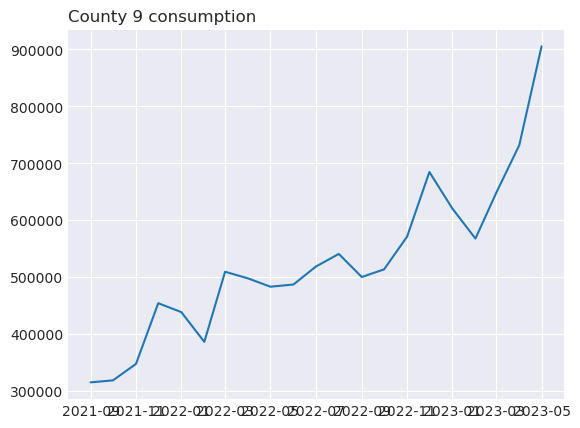

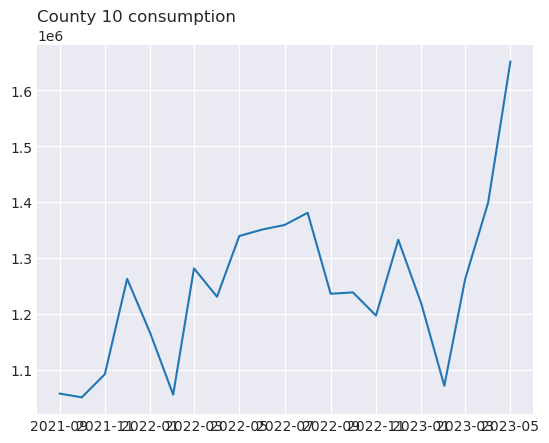

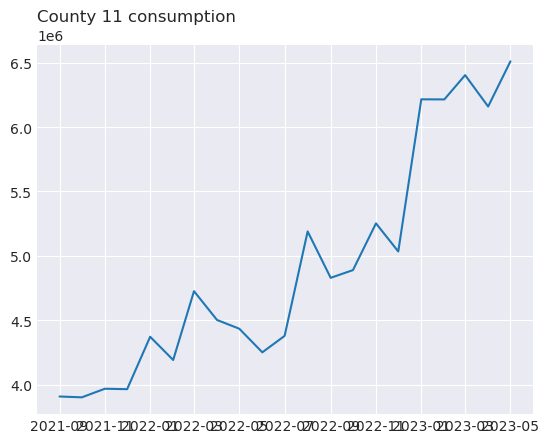

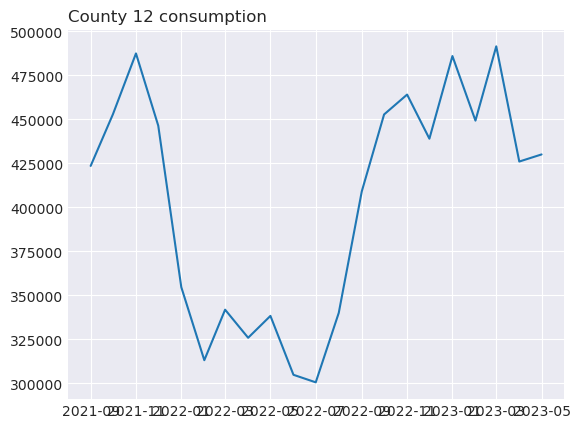

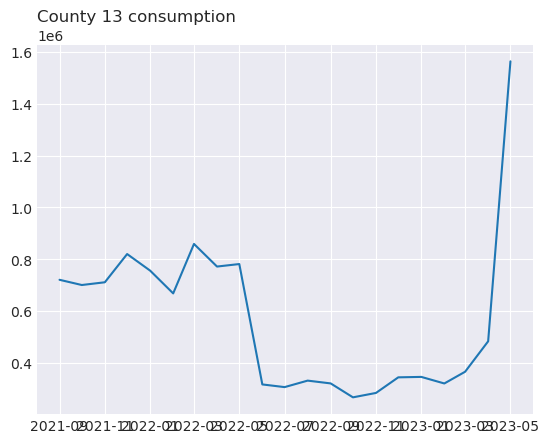

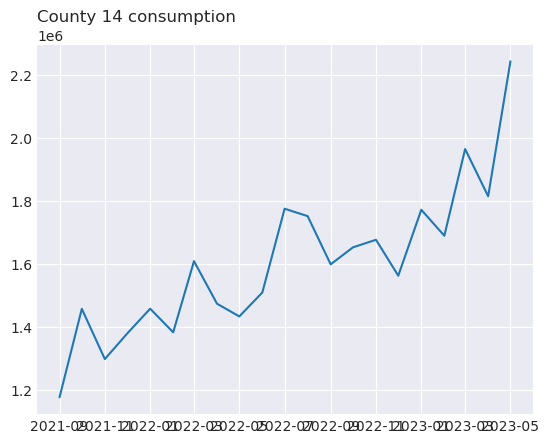

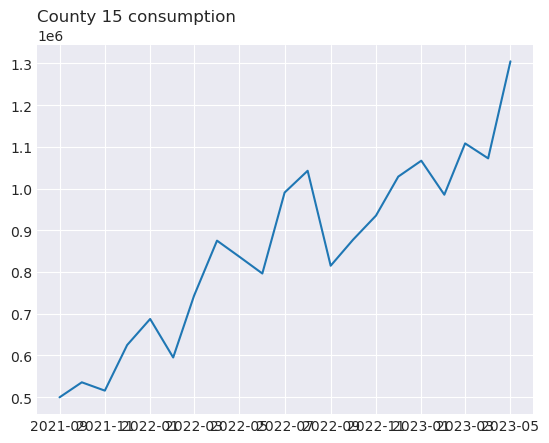

In [10]:
# County 별 consumption plot
for county in df_train['county'].unique():
    plt.title(f'County {county} consumption', fontsize=12, loc='left')
    df_fill_group = df_train.query('county == @county').set_index('datetime')[['target']].groupby(pd.Grouper(freq='MS')).sum().copy()
    plt.plot(df_fill_group.index, df_fill_group['target'])
    plt.show()

In [10]:
# 각 parameter별로 그룹 화 하기
df_month = df_train.set_index('datetime').groupby(['is_business', 'product_type', 'is_consumption', 'county',
                                                  pd.Grouper(freq='MS')])[['target']].sum().reset_index().copy()

In [11]:
df_month.columns

Index(['is_business', 'product_type', 'is_consumption', 'county', 'datetime',
       'target'],
      dtype='object')

In [12]:
# TODO: Stationary
for consumption in df_month['is_consumption'].unique():
    print(f'Is consumption: {consumption}')
    df_fill = df_month.groupby(['is_consumption', 'datetime'], as_index=False)[['target']].sum().copy()
    check = adfuller(df_fill.query('is_consumption == @consumption').set_index('datetime')[['target']])
    pprint.pprint(check)
    if check[1] <= 0.05:
        print("Reject the null hypothesis - the time series is likely stationary.")
    else:
        print("Fail to reject the null hypothesis - the time series may have a unit root and is likely non-stationary.")
    print('')

Is consumption: 0
(1.1075272481770164,
 0.9952803553217605,
 8,
 12,
 {'1%': -4.137829282407408,
  '10%': -2.7144769444444443,
  '5%': -3.1549724074074077},
 366.9931168300063)
Fail to reject the null hypothesis - the time series may have a unit root and is likely non-stationary.

Is consumption: 1
(-1.630846999402135,
 0.4670473909725571,
 6,
 14,
 {'1%': -4.01203360058309,
  '10%': -2.6909873469387753,
  '5%': -3.1041838775510207},
 380.2895443284565)
Fail to reject the null hypothesis - the time series may have a unit root and is likely non-stationary.



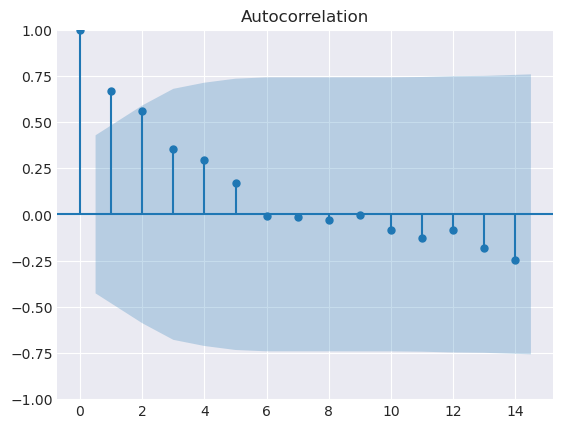

In [14]:
# TODO: Autocorrelation
plot_acf(df_month.groupby('datetime')[['target']].sum())
plt.show()

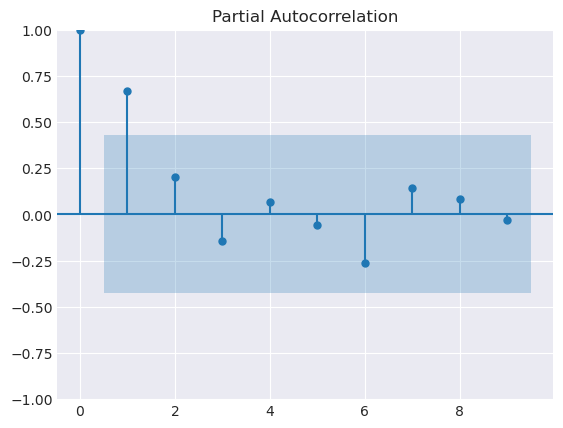

In [15]:
#TODO: Partial Autocorrelation
plot_pacf(df_month.groupby('datetime')[['target']].sum(), lags=9)
plt.show()

In [13]:
# 결측치를... 그냥 중앙값으로 채워보았습니다
df_train['target'].fillna(df_train['target'].median(), inplace=True)

In [14]:
# TODO: ARIMA 모델 적용준비

df_arima = df_train[(df_train['is_consumption'] == 0) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()



In [ ]:
df_arima.plot()
plt.show()

In [ ]:
plot_acf(df_arima)
plt.show()

In [ ]:
plot_pacf(df_arima)
plt.show()

In [ ]:
df_arima_nc = df_train[(df_train['is_consumption'] == 1) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()


In [ ]:
df_arima_nc.plot()
plt.show()

In [ ]:
plot_acf(df_arima_nc)
plt.show()

In [ ]:
plot_pacf(df_arima_nc)
plt.show()

In [15]:
# Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_arima[-336:].plot()
plt.title('Two Week Data', loc='left')
plt.show()

In [ ]:
df_arima_train = df_arima[-336:-24].copy()
df_arima_test = df_arima[-24:].copy()

In [ ]:
# TODO: ARIMA 모델 근데 이제 sarimax를 이용함 예제를 보면서 했기 때문..
sarimax = SARIMAX(endog=df_arima_train, trend='c', freq='h', order=(24, 1, 0),
                  seasonal_order=(0, 0, 0, 24)).fit(disp=True)

In [ ]:
# TODO: 5.31일 예측 구경
pred = sarimax.predict(start='2023-05-31 00:00:00', end='2023-05-31 23:00:00',
                dynamic=False)

In [ ]:
plt.plot(pred, label='Forecast')
plt.plot(df_arima_test, label='Test')
plt.legend()
plt.show()

In [ ]:
print(f'SARIMAX Sample Mean Absolute Error: {round(mean_absolute_error(df_arima_test, pred))}')

In [ ]:
# def mape(y_pred, y_true):
#   return (np.abs(y_pred - y_true)/y_true).mean() * 100

# def mae(y_pred, y_true):
#   return np.abs(y_pred - y_true).mean()

In [16]:
df_arima001 = df_train[(df_train['is_consumption'] == 0) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()

In [17]:
df_arima_train = df_arima001[:-96].copy()
df_arima_test = df_arima001[-96:].copy()

In [18]:
# ARIMA 테스트0
trn_001, tst_001 = df_arima_train[:], df_arima_test[:]

print(trn_001.index)
print(tst_001.index)


DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2023-05-27 14:00:00', '2023-05-27 15:00:00',
               '2023-05-27 16:00:00', '2023-05-27 17:00:00',
               '2023-05-27 18:00:00', '2023-05-27 19:00:00',
               '2023-05-27 20:00:00', '2023-05-27 21:00:00',
               '2023-05-27 22:00:00', '2023-05-27 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=15216, freq=None)
DatetimeIndex(['2023-05-28 00:00:00', '2023-05-28 01:00:00',
               '2023-05-28 02:00:00', '2023-05-28 03:00:00',
               '2023-05-28 04:00:00', '2023-05-28 05:00:00',
               '2023-05-28 06:00:00', '2023-05-28 07:00:00',
               '2023-05-28 08:00:00', '2023-05

In [ ]:
# df_train['target'].fillna(df_train['target'].shift(1).fillna(df_train['target'].shift(-1).mean()))

In [ ]:
print(trn_001.isnull().sum())
print(tst_001.isnull().sum())


In [ ]:
arma_mod_001 = ARIMA(trn_001, order=(24,0,4), trend='t').fit()

In [ ]:
prd_001 = arma_mod_001.predict(start=tst_001.index[0], end=tst_001.index[-1], dynamic=False)


In [ ]:
# 예측 결과 생성

plt.plot(trn_001[-192:], label='Train',)
plt.plot(tst_001, label='Test')
plt.plot(prd_001, label='Prediction')
plt.legend()
plt.show()

In [ ]:
# MAE 계산
mae_value = mean_absolute_error(tst_001, prd_001)

mape_value = mean_absolute_percentage_error(tst_001, prd_001)

# 결과 출력
print(f"MAE: {mae_value:.4f}")
print(f"MAPE: {mape_value:.4f}")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn_001.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn_001.values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn_001)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

In [ ]:
trn_001.diff(1).plot(label="Diff(1)")
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn_001.diff(1).dropna().values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn_001.diff(1).dropna().values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn_001.diff(1).dropna())
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

In [ ]:
arma_mod_001_2 = ARIMA(trn_001, order=(24,1,24), trend='t').fit()
prd_001 = arma_mod_001_2.predict(start=tst_001.index[0], end=tst_001.index[-1], dynamic=False)


In [ ]:
plt.plot(trn_001[-192:], label='Train',)
plt.plot(tst_001, label='Test')
plt.plot(prd_001, label='Prediction')
plt.legend()
plt.show()

# MAE 계산
mae_value = mean_absolute_error(tst_001, prd_001)

mape_value = mean_absolute_percentage_error(tst_001, prd_001)

# 결과 출력
print(f"MAE: {mae_value:.4f}")
print(f"MAPE: {mape_value:.4f}")

# 여기부터 ARIMA테스트
county, is_produce, product_type, 0 0 1

In [ ]:
df_arima_train = df_arima[-336:-24].copy()
df_arima_test = df_arima[-24:].copy()

In [ ]:
# ARIMA 테스트..
trn, tst = df_arima_train[:-72], df_arima_train[-72:]
arma_mod = ARIMA(trn, order=(24,1,4), trend='t', freq='h').fit()

In [ ]:
# 예측 결과 생성
prd = arma_mod.predict(start='2023-05-28 00:00:00', end='2023-05-30 23:00:00', dynamic=False)
plt.plot(tst, label='Test')
plt.plot(prd, label='Prediction')
plt.legend()
plt.show()

In [ ]:
# MAE 계산
mae_value = mean_absolute_error(tst, prd)

# 결과 출력
print(f"MAE: {mae_value:.4f}")

아직 안된 부분:
- rolling std, mean 이런거 확인하는 부분
- stationary 확인이 부족하지 않나?
- 일단 dataframe중 2주일 만 가지고 했는데, 전체를 대상으로 해야함
- 다른 segment들에 대해서 해봐야 할듯, 0-0-3 등등..
- ADF 추가하기

# TODO:
Step: 1시간, 그래서 seasonal freq = 24로 설정
Stationary: adf test로 수치 확인하기
전체 기간으로 확인하기 (현재는 마지막 2주를 보고, 4일 예측)


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

In [ ]:
trn.diff(1).plot(label="Diff(1)")
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.diff(1).dropna().values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.diff(1).dropna().values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn.diff(1).dropna())
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

# 세준님께 궁금한점?

AR
MA 이제 두개 대충 알기만 한 이야기

I는 차분 얘기, => trend?제거?

아직 확실히 모르겠는 부분
window size,
predict size..
다 해결

In [22]:
from pmdarima import auto_arima

auto_model = auto_arima(trn_001, seasonal=True, m=24)  # m은 계절성 주기입니다.

print(auto_model.summary())

KeyboardInterrupt: 

In [20]:
from pmdarima import auto_arima

In [27]:


# ARIMA 모델 자동으로 선택
autoarima_model = auto_arima(trn_001, seasonal=True, m=24, suppress_warnings=True, scoring='mae')

# 최적의 ARIMA 모델의 매개변수 확인
print("최적의 ARIMA 모델 매개변수:", autoarima_model.get_params())

# 최적의 ARIMA 모델 피팅
arma_mod_001 = ARIMA(trn_001, order=autoarima_model.order, trend='t').fit()



: 

In [21]:
auto_arima_model = auto_arima(trn_001, start_p=1, start_q=1,
                             max_p=24, max_q=24, m=24, seasonal=True, # sarima(seasonal=True)
                             d=1, D=1,
                             max_P=3, max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,1,0)[24]             : AIC=187626.921, Time=1.14 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=8.99 sec
 ARIMA(0,1,0)(0,1,2)[24]             : AIC=inf, Time=43.92 sec


: 

In [ ]:
# 예측 수행
prd_001 = arma_mod_001.predict(start=tst_001.index[0], end=tst_001.index[-1], dynamic=False)

# 그림 그림
plt.plot(trn_001[-192:], label='Train',)
plt.plot(tst_001, label='Test')
plt.plot(prd_001, label='Prediction')
plt.legend()
plt.show()

# MAE 계산
mae_value = mean_absolute_error(tst_001, prd_001)

mape_value = mean_absolute_percentage_error(tst_001, prd_001)

# 결과 출력
print(f"MAE: {mae_value:.4f}")
print(f"MAPE: {mape_value:.4f}")

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json

from matplotlib.pylab import rcParams
%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import pprint

# Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


In [2]:
TEST_DATA_PATH = '../data/origin/test/'
TRAIN_DATA_PATH = '../data/origin/train/'

# instead of weather_station_to_county_mapping.csv, use fabiendaniels-mapping-locations-and-county-codes
# https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
county_mapper = '../data/origin/county_lon_lats.csv'

test_csv = f'{TEST_DATA_PATH}test.csv'
test_client_csv = f'{TEST_DATA_PATH}client.csv'
test_electricity_prices_csv = f'{TEST_DATA_PATH}electricity_prices.csv'
test_forecast_weather_csv = f'{TEST_DATA_PATH}forecast_weather.csv'
test_gas_prices_csv = f'{TEST_DATA_PATH}gas_prices.csv'
test_historical_weather_csv = f'{TEST_DATA_PATH}historical_weather.csv'
# test_weather_station_to_county_mapping_csv = f'{TEST_DATA_PATH}weather_station_to_county_mapping.csv'
# test_county_id_to_name_map_json = f'{TEST_DATA_PATH}county_id_to_name_map.json'

train_csv = f'{TRAIN_DATA_PATH}train.csv'
train_client_csv = f'{TRAIN_DATA_PATH}client.csv'
train_electricity_prices_csv = f'{TRAIN_DATA_PATH}electricity_prices.csv'
train_forecast_weather_csv = f'{TRAIN_DATA_PATH}forecast_weather.csv'
train_gas_prices_csv = f'{TRAIN_DATA_PATH}gas_prices.csv'
train_historical_weather_csv = f'{TRAIN_DATA_PATH}historical_weather.csv'
# train_weather_station_to_county_mapping_csv = f'{TRAIN_DATA_PATH}weather_station_to_county_mapping.csv'
# train_county_id_to_name_map_json = f'{TRAIN_DATA_PATH}county_id_to_name_map.json'

In [ ]:
df_train = pd.read_csv(train_csv)

df_train[(df_train['datetime'] >= '2021-09-01 00:00:00') &
         (df_train['datetime'] <= '2021-09-01 23:00:00')]['datetime'].unique()


df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_train['target'].fillna(df_train['target'].median(), inplace=True)

df_train = df_train.set_index('datetime')

df_arima = df_train[(df_train['is_consumption'] == 0) &
         (df_train['is_business'] == 0) &
         (df_train['product_type'] == 1) &
         (df_train['county'] == 0)][['datetime', 'target']].set_index('datetime').copy()